In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [97]:
df = pd.read_csv("eye_data.csv")
df.head()


,timestamp,left_ear,right_ear,avg_ear,label
0,1.767391e+09,0.286410,0.262204,0.274307,0
1,1.767391e+09,0.283290,0.280742,0.282016,0
2,1.767391e+09,0.287855,0.280742,0.284298,0
3,1.767391e+09,0.295712,0.280742,0.288227,0
4,1.767391e+09,0.308641,0.280742,0.294691,0


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1662 entries, 0 to 1661
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  1662 non-null   float64
 1   left_ear   1662 non-null   float64
 2   right_ear  1662 non-null   float64
 3   avg_ear    1662 non-null   float64
 4   label      1662 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 65.1 KB


In [99]:
df.describe()

,timestamp,left_ear,right_ear,avg_ear,label
count,1.662000e+03,1662.000000,1662.000000,1662.000000,1662.000000
mean,1.767391e+09,0.190902,0.177525,0.184213,0.607100
std,2.364299e+01,0.117874,0.119634,0.117909,0.488542
min,1.767391e+09,0.000000,0.000000,0.008285,0.000000
25%,1.767391e+09,0.053903,0.049056,0.050607,0.000000
50%,1.767391e+09,0.209719,0.201377,0.204955,1.000000
75%,1.767391e+09,0.292727,0.288394,0.292056,1.000000
max,1.767391e+09,0.407433,0.412294,0.409240,1.000000


In [77]:
df['label'].value_counts(normalize=True)


label
1    0.6071
0    0.3929
Name: proportion, dtype: float64

In [100]:
df = df.dropna()
df = df[(df['avg_ear'] > 0.05) & (df['avg_ear'] < 0.5)]


## Feature 1: Average EAR Smooth

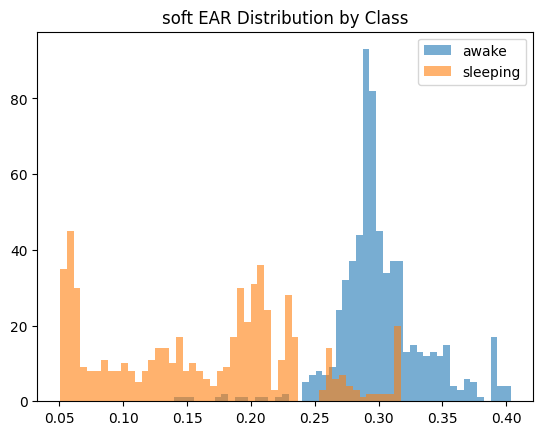

In [101]:
# we use a window of 5 frames (~0.15 secs) to ignore quick blinks
df['avg_ear_smooth'] = df['avg_ear'].rolling(window=5, center=True).mean()
df = df.dropna()
df.head()

plt.hist(df[df.label==0]['avg_ear_smooth'], bins=50, alpha=0.6, label='awake')
plt.hist(df[df.label==1]['avg_ear_smooth'], bins=50, alpha=0.6, label='sleeping')
plt.legend()
plt.title("soft EAR Distribution by Class")
plt.show()


## Feature 2: Differential EAR

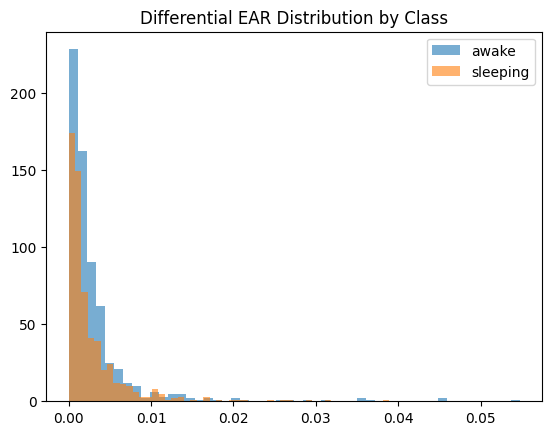

In [102]:
# differential EAR
df['diff_ear_smooth'] = df['avg_ear_smooth'].diff().abs()
df = df.dropna()
df.head()
plt.hist(df[df.label==0]['diff_ear_smooth'], bins=50, alpha=0.6, label='awake')
plt.hist(df[df.label==1]['diff_ear_smooth'], bins=50, alpha=0.6, label='sleeping')
plt.legend()
plt.title("Differential EAR Distribution by Class")
plt.show()


## Feature 3: Local EAR variance 

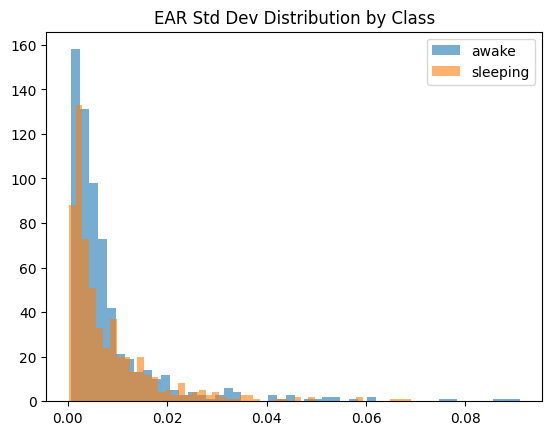

In [103]:
df['ear_std'] = df['avg_ear_smooth'].rolling(10).std()
df = df.dropna()
df.head()
plt.hist(df[df.label==0]['ear_std'], bins=50, alpha=0.6, label='awake')
plt.hist(df[df.label==1]['ear_std'], bins=50, alpha=0.6, label='sleeping')
plt.legend()
plt.title("EAR Std Dev Distribution by Class")
plt.show()

In [104]:
df.head()

,timestamp,left_ear,right_ear,avg_ear,label,avg_ear_smooth,diff_ear_smooth,ear_std
12,1.767391e+09,0.307367,0.280742,0.294054,0,0.294054,0.000107,0.001907
13,1.767391e+09,0.307367,0.280742,0.294054,0,0.293273,0.000781,0.001017
14,1.767391e+09,0.307367,0.280742,0.294054,0,0.292777,0.000497,0.000637
15,1.767391e+09,0.307367,0.272933,0.290150,0,0.292280,0.000497,0.000819
16,1.767391e+09,0.305805,0.277335,0.291570,0,0.292576,0.000297,0.000871


## Prediction models.

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler



In [106]:
X = df[['avg_ear_smooth', 'diff_ear_smooth', 'ear_std']] 
y = df['label']

#scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

## Model 1: Bayes

In [107]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

acc_gnb = accuracy_score(y_test, y_pred_gnb)
print(f"Precisión (Accuracy): {acc_gnb:.4f}")
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_gnb))

Precisión (Accuracy): 0.9489
Matriz de Confusión:
 [[200   2]
 [ 17 153]]


In [108]:
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_gnb))
recall = recall_score(y_test, y_pred_gnb)
precision = precision_score(y_test, y_pred_gnb)
f1 = f1_score(y_test, y_pred_gnb)
print(f"Recall: {recall:.4f}, Precision: {precision:.4f}, F1-Score: {f1:.4f}")


Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95       202
           1       0.99      0.90      0.94       170

    accuracy                           0.95       372
   macro avg       0.95      0.95      0.95       372
weighted avg       0.95      0.95      0.95       372

Recall: 0.9000, Precision: 0.9871, F1-Score: 0.9415


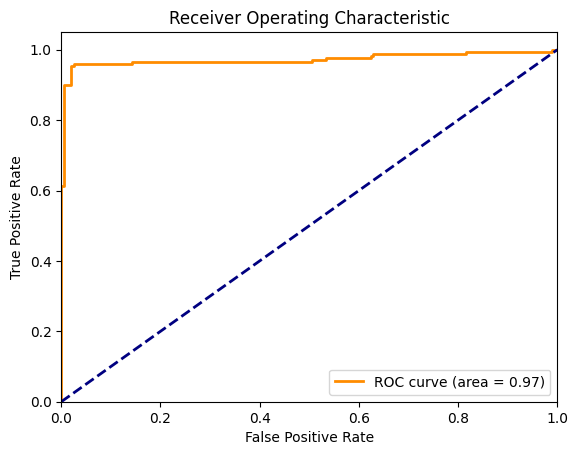

AUC: 0.9724


In [109]:
#AUC ROC Curve

y_prob_gnb = gnb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_gnb)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc:.4f}")

In [110]:
## temporal memory model (HMM-like)
X = df[['avg_ear_smooth','diff_ear_smooth','ear_std']].values
y = df['label'].values

mu0 = X[y==0].mean(axis=0)
mu1 = X[y==1].mean(axis=0)

Sigma0 = np.cov(X[y==0].T) + 1e-6*np.eye(3)
Sigma1 = np.cov(X[y==1].T) + 1e-6*np.eye(3)

# transition matrix
P = np.array([[0.995, 0.005],
              [0.010, 0.990]])

joblib.dump((mu0, Sigma0, mu1, Sigma1, P, scaler), "bayes_model.pkl")

['bayes_model.pkl']

## Model 2: SVC

In [88]:
svc = SVC(kernel='rbf', C=1.0, gamma='scale')
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

acc_svc = accuracy_score(y_test, y_pred_svc)
print(f"Precisión (Accuracy) SVC: {acc_svc:.4f}")
print("Matriz de Confusión SVC:\n", confusion_matrix(y_test, y_pred_svc))


Precisión (Accuracy) SVC: 0.9462
Matriz de Confusión SVC:
 [[201   1]
 [ 19 151]]


In [89]:
print("Reporte de Clasificación SVC:\n", classification_report(y_test, y_pred_svc))
recall_svc = recall_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc)
print(f"SVC Recall: {recall_svc:.4f}, Precision: {precision_svc:.4f}, F1-Score: {f1_svc:.4f}")


Reporte de Clasificación SVC:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       202
           1       0.99      0.89      0.94       170

    accuracy                           0.95       372
   macro avg       0.95      0.94      0.95       372
weighted avg       0.95      0.95      0.95       372

SVC Recall: 0.8882, Precision: 0.9934, F1-Score: 0.9379


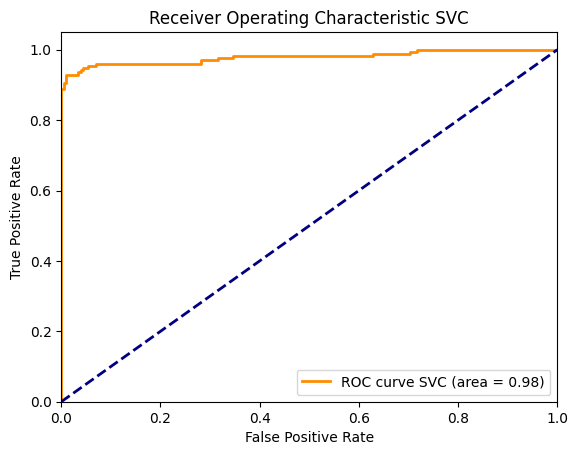

AUC SVC: 0.9790


In [90]:
y_prob_svc = svc.decision_function(X_test)
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_prob_svc)
roc_auc_svc = auc(fpr_svc, tpr_svc)
plt.figure()
plt.plot(fpr_svc, tpr_svc, color='darkorange', lw=2, label='ROC curve SVC (area = %0.2f)' % roc_auc_svc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic SVC')
plt.legend(loc="lower right")
plt.show()

print(f"AUC SVC: {roc_auc_svc:.4f}")

## 3) Logistic regression

In [91]:
## logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
acc_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Precisión (Accuracy) Logistic Regression: {acc_logreg:.4f}")
print("Matriz de Confusión Logistic Regression:\n", confusion_matrix(y_test, y_pred_logreg))
print("Reporte de Clasificación Logistic Regression:\n", classification_report(y_test, y_pred_logreg))
recall_logreg = recall_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)
print(f"Logistic Regression Recall: {recall_logreg:.4f}, Precision: {precision_logreg:.4f}, F1-Score: {f1_logreg:.4f}")



Precisión (Accuracy) Logistic Regression: 0.9570
Matriz de Confusión Logistic Regression:
 [[200   2]
 [ 14 156]]
Reporte de Clasificación Logistic Regression:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96       202
           1       0.99      0.92      0.95       170

    accuracy                           0.96       372
   macro avg       0.96      0.95      0.96       372
weighted avg       0.96      0.96      0.96       372

Logistic Regression Recall: 0.9176, Precision: 0.9873, F1-Score: 0.9512


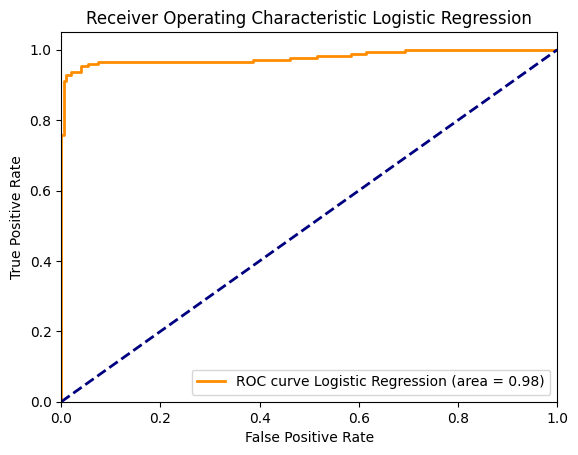

AUC Logistic Regression: 0.9784


In [92]:
y_prob_logreg = logreg.predict_proba(X_test)[:, 1]
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test,
                                                        y_prob_logreg)  
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
plt.figure()
plt.plot(fpr_logreg, tpr_logreg, color='darkorange', lw=2,
         label='ROC curve Logistic Regression (area = %0.2f)' % roc_auc_logreg)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Logistic Regression')
plt.legend(loc="lower right")
plt.show()
print(f"AUC Logistic Regression: {roc_auc_logreg:.4f}")

In [93]:
logreg = LogisticRegression(class_weight={0:1, 1:4}, max_iter=1000)
logreg.fit(X_train, y_train)

y_proba = logreg.predict_proba(X_test)[:,1]
for t in np.linspace(0.1, 0.5, 9):
    y_pred = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    recall = tp / (tp + fn)
    precision = tp / (tp + fp) if tp+fp>0 else 0
    print(f"τ={t:.2f}  Recall={recall:.3f}  Precision={precision:.3f}  FN={fn}  FP={fp}")

τ=0.10  Recall=1.000  Precision=0.531  FN=0  FP=150
τ=0.15  Recall=1.000  Precision=0.545  FN=0  FP=142
τ=0.20  Recall=0.994  Precision=0.571  FN=1  FP=127
τ=0.25  Recall=0.982  Precision=0.609  FN=3  FP=107
τ=0.30  Recall=0.971  Precision=0.655  FN=5  FP=87
τ=0.35  Recall=0.971  Precision=0.673  FN=5  FP=80
τ=0.40  Recall=0.965  Precision=0.710  FN=6  FP=67
τ=0.45  Recall=0.965  Precision=0.800  FN=6  FP=41
τ=0.50  Recall=0.965  Precision=0.863  FN=6  FP=26


In [ ]:
joblib.dump(logreg, "sleep_model.pkl") # without scaler
#joblib.dump((scaler, logreg), "sleep_model.pkl")


['sleep_model.pkl']